##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Fine-tuning a BERT model

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/official_models/tutorials/fine_tune_bert.ipynb"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/official/colab/fine_tuning_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

In this example, we will work through fine-tuning a BERT model using the tensorflow-models PIP package.

The pretrained BERT model this tutorial is based on is also available on [TensorFlow Hub](https://tensorflow.org/hub), to see how to use it refer to the [Hub Appendix](#hub_bert)

## Setup

### Install the TensorFlow Model Garden pip package

*  `tf-models-official` is the stable Model Garden package. Note that it may not include the latest changes in the `tensorflow_models` github repo. To include latest changes, you may install `tf-models-nightly`,
which is the nightly Model Garden package created daily automatically.
*  pip will install all models and dependencies automatically.

In [2]:
!pip install -q tf-models-official==2.3.0

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


### Imports

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

### Resources

This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

You can get a pre-trained BERT encoder from [TensorFlow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2):

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

## The data
For this example we used the [GLUE MRPC dataset from TFDS](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc).

This dataset is not set up so that it can be directly fed into the BERT model, so this section also handles the necessary preprocessing.

### Get the dataset from TensorFlow Datasets

The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

*   Number of labels: 2.
*   Size of training dataset: 3668.
*   Size of evaluation dataset: 408.
*   Maximum sequence length of training and evaluation dataset: 128.


In [6]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incompleteKZIBN9/glue-train.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incompleteKZIBN9/glue-validation.tfrecord


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0.incompleteKZIBN9/glue-test.tfrecord
Dataset glue downloaded and prepared to /home/kbuilder/tensorflow_datasets/glue/mrpc/1.0.0. Subsequent calls will reuse this data.


In [7]:
list(glue.keys())

['test', 'train', 'validation']

The `info` object describes the dataset and it's features:

In [8]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

The two classes are:

In [9]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:

In [10]:
glue_train = glue['train']

for key, value in glue_train.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


### The BERT tokenizer

To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training.

The BERT tokenizer used in this tutorial is written in pure Python (It's not built out of TensorFlow ops). So you can't just plug it into your model as a `keras.layer` like you can with `preprocessing.TextVectorization`.

The following code rebuilds the tokenizer that was used by the base model:

In [11]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Tokenize a sentence:

In [12]:
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


### Preprocess the data

The section manually preprocessed the dataset into the format expected by the model.

This dataset is small, so preprocessing can be done quickly and easily in memory. For larger datasets the `tf_models` library includes some tools for preprocessing and re-serializing a dataset. See [Appendix: Re-encoding a large dataset](#re_encoding_tools) for details.

#### Encode the sentences

The model expects its two inputs sentences to be concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

In [13]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Start by encoding all the sentences while appending a `[SEP]` token, and packing them into ragged-tensors:

In [14]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s.numpy()))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

In [15]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


Now prepend a `[CLS]` token, and concatenate the ragged tensors to form a single `input_word_ids` tensor for each example. `RaggedTensor.to_tensor()` zero pads to the longest sequence.

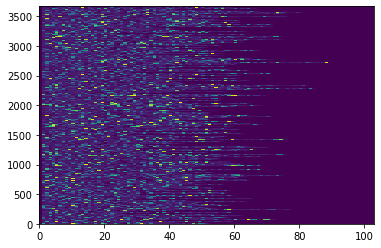

In [16]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

#### Mask and input type

The model expects two additional inputs:

* The input mask
* The input type

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the `input_word_ids`, and contains a `1` anywhere the `input_word_ids` is not padding.

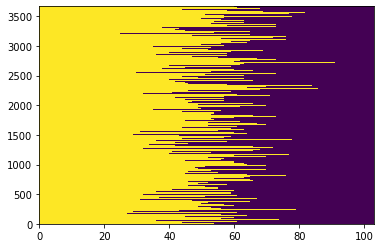

In [17]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

The "input type" also has the same shape, but inside the non-padded region, contains a `0` or a `1` indicating which sentence the token is a part of. 

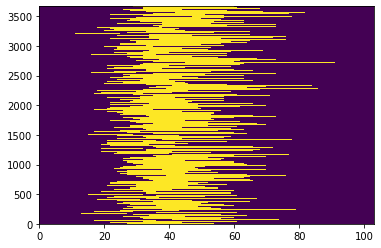

In [18]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

#### Put it all together

Collect the above text parsing code into a single function, and apply it to each split of the `glue/mrpc` dataset.

In [19]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [20]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [21]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## The model

### Build the model


The first step is to download the configuration  for the pre-trained model.


In [22]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [23]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

The classifier has three inputs and one output:

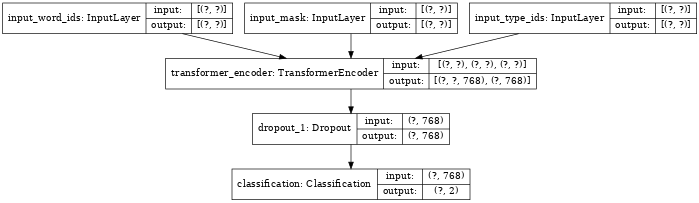

In [24]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

In [25]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.08382261,  0.34465584],
       [ 0.02057236,  0.24053624],
       [ 0.04930754,  0.1117427 ],
       [ 0.17041089,  0.20810834],
       [ 0.21667874,  0.2840511 ],
       [ 0.02325345,  0.33799925],
       [-0.06198866,  0.13532838],
       [ 0.084592  ,  0.20711854],
       [-0.04323687,  0.17096342],
       [ 0.23759182,  0.16801538]], dtype=float32)

The `TransformerEncoder` in the center of the classifier above **is** the `bert_encoder`.

Inspecting the encoder, we see its stack of `Transformer` layers connected to those same three inputs:

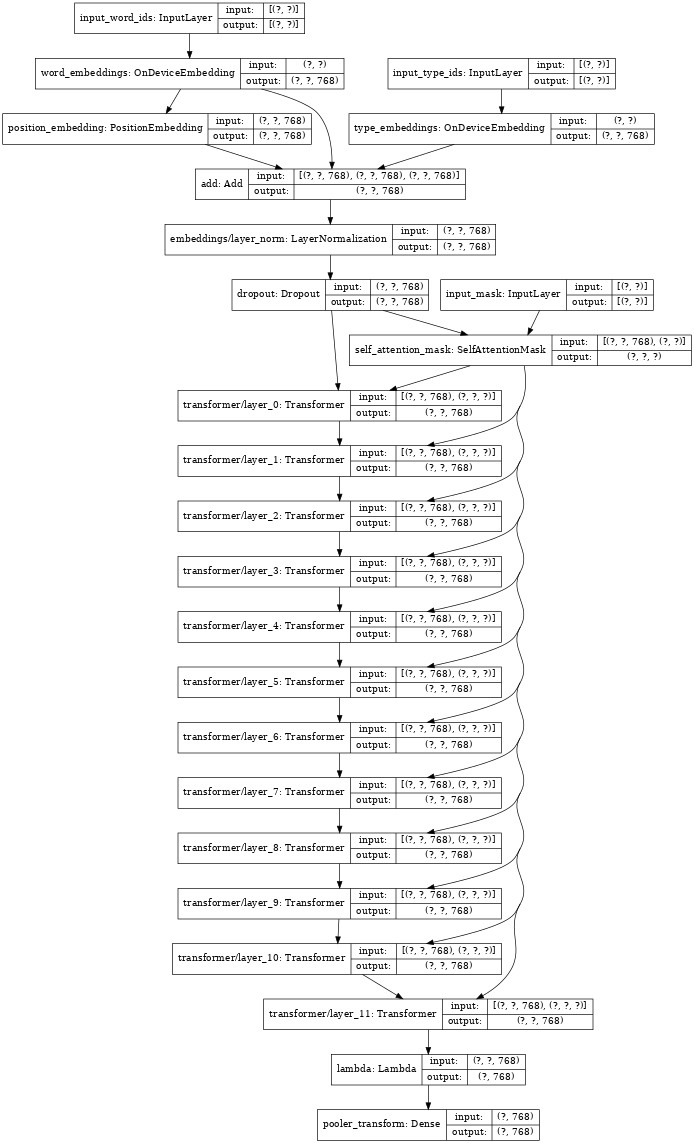

In [26]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights

When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [27]:
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Note: The pretrained `TransformerEncoder` is also available on [TensorFlow Hub](https://tensorflow.org/hub). See the [Hub appendix](#hub_bert) for details. 

### Set up the optimizer

BERT adopts the Adam optimizer with weight decay (aka "[AdamW](https://arxiv.org/abs/1711.05101)").
It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [28]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

This returns an `AdamWeightDecay`  optimizer with the learning rate schedule set:

In [29]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

To see an example of how to customize the optimizer and it's schedule, see the [Optimizer schedule appendix](#optiizer_schedule).

### Train the model

The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [30]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3


  1/115 [..............................] - ETA: 10s - loss: 0.7206 - accuracy: 0.4688

  2/115 [..............................] - ETA: 17s - loss: 0.7217 - accuracy: 0.4219

  3/115 [..............................] - ETA: 19s - loss: 0.7255 - accuracy: 0.4062

  4/115 [>.............................] - ETA: 19s - loss: 0.7210 - accuracy: 0.4219

  5/115 [>.............................] - ETA: 20s - loss: 0.7210 - accuracy: 0.4125

  6/115 [>.............................] - ETA: 20s - loss: 0.7168 - accuracy: 0.4167

  7/115 [>.............................] - ETA: 20s - loss: 0.7147 - accuracy: 0.4330

  8/115 [=>............................] - ETA: 20s - loss: 0.7067 - accuracy: 0.4609

  9/115 [=>............................] - ETA: 20s - loss: 0.7084 - accuracy: 0.4444

 10/115 [=>............................] - ETA: 20s - loss: 0.7125 - accuracy: 0.4250

 11/115 [=>............................] - ETA: 20s - loss: 0.7098 - accuracy: 0.4347

 12/115 [==>...........................] - ETA: 20s - loss: 0.7086 - accuracy: 0.4427

 13/115 [==>...........................] - ETA: 20s - loss: 0.7088 - accuracy: 0.4447

 14/115 [==>...........................] - ETA: 20s - loss: 0.7091 - accuracy: 0.4509

 15/115 [==>...........................] - ETA: 19s - loss: 0.7080 - accuracy: 0.4583

 16/115 [===>..........................] - ETA: 19s - loss: 0.7053 - accuracy: 0.4688

 17/115 [===>..........................] - ETA: 19s - loss: 0.7023 - accuracy: 0.4816

 18/115 [===>..........................] - ETA: 19s - loss: 0.6996 - accuracy: 0.4878

 19/115 [===>..........................] - ETA: 19s - loss: 0.6950 - accuracy: 0.5016

 20/115 [====>.........................] - ETA: 19s - loss: 0.6923 - accuracy: 0.5109

 21/115 [====>.........................] - ETA: 18s - loss: 0.6911 - accuracy: 0.5179

 22/115 [====>.........................] - ETA: 18s - loss: 0.6868 - accuracy: 0.5284

 23/115 [=====>........................] - ETA: 18s - loss: 0.6847 - accuracy: 0.5353

 24/115 [=====>........................] - ETA: 18s - loss: 0.6853 - accuracy: 0.5378

 25/115 [=====>........................] - ETA: 18s - loss: 0.6810 - accuracy: 0.5475

 26/115 [=====>........................] - ETA: 18s - loss: 0.6780 - accuracy: 0.5553

 27/115 [======>.......................] - ETA: 17s - loss: 0.6754 - accuracy: 0.5602

 28/115 [======>.......................] - ETA: 17s - loss: 0.6695 - accuracy: 0.5692

 29/115 [======>.......................] - ETA: 17s - loss: 0.6694 - accuracy: 0.5711

 30/115 [======>.......................] - ETA: 17s - loss: 0.6725 - accuracy: 0.5698

 31/115 [=======>......................] - ETA: 17s - loss: 0.6695 - accuracy: 0.5746

 32/115 [=======>......................] - ETA: 16s - loss: 0.6672 - accuracy: 0.5781

 33/115 [=======>......................] - ETA: 16s - loss: 0.6682 - accuracy: 0.5795

 34/115 [=======>......................] - ETA: 16s - loss: 0.6694 - accuracy: 0.5800

 35/115 [========>.....................] - ETA: 16s - loss: 0.6693 - accuracy: 0.5821

 36/115 [========>.....................] - ETA: 16s - loss: 0.6695 - accuracy: 0.5842

 37/115 [========>.....................] - ETA: 15s - loss: 0.6673 - accuracy: 0.5878

 38/115 [========>.....................] - ETA: 15s - loss: 0.6655 - accuracy: 0.5905

 39/115 [=========>....................] - ETA: 15s - loss: 0.6670 - accuracy: 0.5897

 40/115 [=========>....................] - ETA: 15s - loss: 0.6654 - accuracy: 0.5930

 41/115 [=========>....................] - ETA: 15s - loss: 0.6672 - accuracy: 0.5922

 42/115 [=========>....................] - ETA: 14s - loss: 0.6672 - accuracy: 0.5923

 43/115 [==========>...................] - ETA: 14s - loss: 0.6656 - accuracy: 0.5945

 44/115 [==========>...................] - ETA: 14s - loss: 0.6640 - accuracy: 0.5973

 45/115 [==========>...................] - ETA: 14s - loss: 0.6639 - accuracy: 0.5979

 46/115 [===========>..................] - ETA: 14s - loss: 0.6631 - accuracy: 0.5992

 47/115 [===========>..................] - ETA: 13s - loss: 0.6617 - accuracy: 0.6017

 48/115 [===========>..................] - ETA: 13s - loss: 0.6608 - accuracy: 0.6022

 49/115 [===========>..................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6046

 50/115 [============>.................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6050

 51/115 [============>.................] - ETA: 13s - loss: 0.6602 - accuracy: 0.6060

 52/115 [============>.................] - ETA: 12s - loss: 0.6580 - accuracy: 0.6094

 53/115 [============>.................] - ETA: 12s - loss: 0.6568 - accuracy: 0.6114

 54/115 [=============>................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6123

 55/115 [=============>................] - ETA: 12s - loss: 0.6547 - accuracy: 0.6136

 56/115 [=============>................] - ETA: 12s - loss: 0.6536 - accuracy: 0.6150

 57/115 [=============>................] - ETA: 11s - loss: 0.6507 - accuracy: 0.6190

 58/115 [==============>...............] - ETA: 11s - loss: 0.6486 - accuracy: 0.6218

 59/115 [==============>...............] - ETA: 11s - loss: 0.6474 - accuracy: 0.6234

 60/115 [==============>...............] - ETA: 11s - loss: 0.6465 - accuracy: 0.6250

 61/115 [==============>...............] - ETA: 11s - loss: 0.6472 - accuracy: 0.6240

 62/115 [===============>..............] - ETA: 10s - loss: 0.6457 - accuracy: 0.6255

 63/115 [===============>..............] - ETA: 10s - loss: 0.6446 - accuracy: 0.6270

 64/115 [===============>..............] - ETA: 10s - loss: 0.6445 - accuracy: 0.6274

 65/115 [===============>..............] - ETA: 10s - loss: 0.6440 - accuracy: 0.6279

 66/115 [================>.............] - ETA: 10s - loss: 0.6434 - accuracy: 0.6297

 67/115 [================>.............] - ETA: 9s - loss: 0.6420 - accuracy: 0.6311 

 68/115 [================>.............] - ETA: 9s - loss: 0.6420 - accuracy: 0.6310

 69/115 [=================>............] - ETA: 9s - loss: 0.6417 - accuracy: 0.6313

 70/115 [=================>............] - ETA: 9s - loss: 0.6406 - accuracy: 0.6330

 71/115 [=================>............] - ETA: 9s - loss: 0.6389 - accuracy: 0.6351

 72/115 [=================>............] - ETA: 8s - loss: 0.6379 - accuracy: 0.6363

 73/115 [==================>...........] - ETA: 8s - loss: 0.6369 - accuracy: 0.6374

 74/115 [==================>...........] - ETA: 8s - loss: 0.6360 - accuracy: 0.6389

 75/115 [==================>...........] - ETA: 8s - loss: 0.6350 - accuracy: 0.6400

 76/115 [==================>...........] - ETA: 8s - loss: 0.6341 - accuracy: 0.6414

 77/115 [===================>..........] - ETA: 7s - loss: 0.6339 - accuracy: 0.6416

 78/115 [===================>..........] - ETA: 7s - loss: 0.6341 - accuracy: 0.6418

 79/115 [===================>..........] - ETA: 7s - loss: 0.6337 - accuracy: 0.6432

 80/115 [===================>..........] - ETA: 7s - loss: 0.6331 - accuracy: 0.6438

 81/115 [====================>.........] - ETA: 6s - loss: 0.6336 - accuracy: 0.6443

 82/115 [====================>.........] - ETA: 6s - loss: 0.6319 - accuracy: 0.6460

 83/115 [====================>.........] - ETA: 6s - loss: 0.6325 - accuracy: 0.6457

 84/115 [====================>.........] - ETA: 6s - loss: 0.6313 - accuracy: 0.6473

 85/115 [=====================>........] - ETA: 6s - loss: 0.6299 - accuracy: 0.6489

 86/115 [=====================>........] - ETA: 5s - loss: 0.6271 - accuracy: 0.6515

 87/115 [=====================>........] - ETA: 5s - loss: 0.6268 - accuracy: 0.6523

 88/115 [=====================>........] - ETA: 5s - loss: 0.6251 - accuracy: 0.6538

 89/115 [======================>.......] - ETA: 5s - loss: 0.6264 - accuracy: 0.6524

 90/115 [======================>.......] - ETA: 5s - loss: 0.6254 - accuracy: 0.6528

 91/115 [======================>.......] - ETA: 4s - loss: 0.6255 - accuracy: 0.6525

 92/115 [=======================>......] - ETA: 4s - loss: 0.6263 - accuracy: 0.6515

 93/115 [=======================>......] - ETA: 4s - loss: 0.6262 - accuracy: 0.6509

 94/115 [=======================>......] - ETA: 4s - loss: 0.6257 - accuracy: 0.6513

 95/115 [=======================>......] - ETA: 4s - loss: 0.6255 - accuracy: 0.6513

 96/115 [========================>.....] - ETA: 3s - loss: 0.6256 - accuracy: 0.6514

 97/115 [========================>.....] - ETA: 3s - loss: 0.6255 - accuracy: 0.6514

 98/115 [========================>.....] - ETA: 3s - loss: 0.6255 - accuracy: 0.6515

 99/115 [========================>.....] - ETA: 3s - loss: 0.6252 - accuracy: 0.6525

100/115 [=========================>....] - ETA: 3s - loss: 0.6243 - accuracy: 0.6534

101/115 [=========================>....] - ETA: 2s - loss: 0.6231 - accuracy: 0.6541

102/115 [=========================>....] - ETA: 2s - loss: 0.6205 - accuracy: 0.6566

103/115 [=========================>....] - ETA: 2s - loss: 0.6200 - accuracy: 0.6569

104/115 [==========================>...] - ETA: 2s - loss: 0.6198 - accuracy: 0.6575

105/115 [==========================>...] - ETA: 2s - loss: 0.6198 - accuracy: 0.6580

106/115 [==========================>...] - ETA: 1s - loss: 0.6201 - accuracy: 0.6580

107/115 [==========================>...] - ETA: 1s - loss: 0.6206 - accuracy: 0.6580

108/115 [===========================>..] - ETA: 1s - loss: 0.6188 - accuracy: 0.6594

109/115 [===========================>..] - ETA: 1s - loss: 0.6183 - accuracy: 0.6591

110/115 [===========================>..] - ETA: 1s - loss: 0.6187 - accuracy: 0.6591

111/115 [===========================>..] - ETA: 0s - loss: 0.6174 - accuracy: 0.6596

112/115 [============================>.] - ETA: 0s - loss: 0.6165 - accuracy: 0.6599

113/115 [============================>.] - ETA: 0s - loss: 0.6163 - accuracy: 0.6607

114/115 [============================>.] - ETA: 0s - loss: 0.6146 - accuracy: 0.6623

115/115 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6611

115/115 [==============================] - 26s 222ms/step - loss: 0.6151 - accuracy: 0.6611 - val_loss: 0.5462 - val_accuracy: 0.7451


Epoch 2/3


  1/115 [..............................] - ETA: 10s - loss: 0.5683 - accuracy: 0.6875

  2/115 [..............................] - ETA: 16s - loss: 0.5281 - accuracy: 0.7969

  3/115 [..............................] - ETA: 18s - loss: 0.5331 - accuracy: 0.7917

  4/115 [>.............................] - ETA: 19s - loss: 0.5303 - accuracy: 0.7812

  5/115 [>.............................] - ETA: 20s - loss: 0.5354 - accuracy: 0.7625

  6/115 [>.............................] - ETA: 20s - loss: 0.5287 - accuracy: 0.7656

  7/115 [>.............................] - ETA: 20s - loss: 0.5242 - accuracy: 0.7679

  8/115 [=>............................] - ETA: 20s - loss: 0.5242 - accuracy: 0.7656

  9/115 [=>............................] - ETA: 20s - loss: 0.5240 - accuracy: 0.7639

 10/115 [=>............................] - ETA: 20s - loss: 0.5131 - accuracy: 0.7719

 11/115 [=>............................] - ETA: 20s - loss: 0.5180 - accuracy: 0.7642

 12/115 [==>...........................] - ETA: 20s - loss: 0.5132 - accuracy: 0.7682

 13/115 [==>...........................] - ETA: 20s - loss: 0.5079 - accuracy: 0.7716

 14/115 [==>...........................] - ETA: 20s - loss: 0.5129 - accuracy: 0.7679

 15/115 [==>...........................] - ETA: 19s - loss: 0.5147 - accuracy: 0.7688

 16/115 [===>..........................] - ETA: 19s - loss: 0.5082 - accuracy: 0.7773

 17/115 [===>..........................] - ETA: 19s - loss: 0.5055 - accuracy: 0.7776

 18/115 [===>..........................] - ETA: 19s - loss: 0.5096 - accuracy: 0.7743

 19/115 [===>..........................] - ETA: 19s - loss: 0.5065 - accuracy: 0.7763

 20/115 [====>.........................] - ETA: 19s - loss: 0.5072 - accuracy: 0.7734

 21/115 [====>.........................] - ETA: 18s - loss: 0.5141 - accuracy: 0.7664

 22/115 [====>.........................] - ETA: 18s - loss: 0.5116 - accuracy: 0.7685

 23/115 [=====>........................] - ETA: 18s - loss: 0.5111 - accuracy: 0.7704

 24/115 [=====>........................] - ETA: 18s - loss: 0.5132 - accuracy: 0.7708

 25/115 [=====>........................] - ETA: 18s - loss: 0.5109 - accuracy: 0.7700

 26/115 [=====>........................] - ETA: 18s - loss: 0.5081 - accuracy: 0.7728

 27/115 [======>.......................] - ETA: 17s - loss: 0.5080 - accuracy: 0.7720

 28/115 [======>.......................] - ETA: 17s - loss: 0.5038 - accuracy: 0.7746

 29/115 [======>.......................] - ETA: 17s - loss: 0.5011 - accuracy: 0.7769

 30/115 [======>.......................] - ETA: 17s - loss: 0.4969 - accuracy: 0.7781

 31/115 [=======>......................] - ETA: 17s - loss: 0.4968 - accuracy: 0.7772

 32/115 [=======>......................] - ETA: 16s - loss: 0.4931 - accuracy: 0.7822

 33/115 [=======>......................] - ETA: 16s - loss: 0.4931 - accuracy: 0.7812

 34/115 [=======>......................] - ETA: 16s - loss: 0.4925 - accuracy: 0.7794

 35/115 [========>.....................] - ETA: 16s - loss: 0.4887 - accuracy: 0.7821

 36/115 [========>.....................] - ETA: 16s - loss: 0.4874 - accuracy: 0.7821

 37/115 [========>.....................] - ETA: 15s - loss: 0.4886 - accuracy: 0.7812

 38/115 [========>.....................] - ETA: 15s - loss: 0.4885 - accuracy: 0.7804

 39/115 [=========>....................] - ETA: 15s - loss: 0.4869 - accuracy: 0.7812

 40/115 [=========>....................] - ETA: 15s - loss: 0.4839 - accuracy: 0.7828

 41/115 [=========>....................] - ETA: 15s - loss: 0.4838 - accuracy: 0.7820

 42/115 [=========>....................] - ETA: 14s - loss: 0.4812 - accuracy: 0.7842

 43/115 [==========>...................] - ETA: 14s - loss: 0.4816 - accuracy: 0.7834

 44/115 [==========>...................] - ETA: 14s - loss: 0.4834 - accuracy: 0.7820

 45/115 [==========>...................] - ETA: 14s - loss: 0.4831 - accuracy: 0.7840

 46/115 [===========>..................] - ETA: 14s - loss: 0.4828 - accuracy: 0.7840

 47/115 [===========>..................] - ETA: 13s - loss: 0.4802 - accuracy: 0.7852

 48/115 [===========>..................] - ETA: 13s - loss: 0.4813 - accuracy: 0.7858

 49/115 [===========>..................] - ETA: 13s - loss: 0.4801 - accuracy: 0.7864

 50/115 [============>.................] - ETA: 13s - loss: 0.4800 - accuracy: 0.7844

 51/115 [============>.................] - ETA: 13s - loss: 0.4764 - accuracy: 0.7855

 52/115 [============>.................] - ETA: 12s - loss: 0.4730 - accuracy: 0.7879

 53/115 [============>.................] - ETA: 12s - loss: 0.4706 - accuracy: 0.7901

 54/115 [=============>................] - ETA: 12s - loss: 0.4697 - accuracy: 0.7894

 55/115 [=============>................] - ETA: 12s - loss: 0.4699 - accuracy: 0.7886

 56/115 [=============>................] - ETA: 12s - loss: 0.4711 - accuracy: 0.7879

 57/115 [=============>................] - ETA: 11s - loss: 0.4686 - accuracy: 0.7895

 58/115 [==============>...............] - ETA: 11s - loss: 0.4682 - accuracy: 0.7904

 59/115 [==============>...............] - ETA: 11s - loss: 0.4675 - accuracy: 0.7903

 60/115 [==============>...............] - ETA: 11s - loss: 0.4680 - accuracy: 0.7901

 61/115 [==============>...............] - ETA: 11s - loss: 0.4676 - accuracy: 0.7905

 62/115 [===============>..............] - ETA: 10s - loss: 0.4655 - accuracy: 0.7918

 63/115 [===============>..............] - ETA: 10s - loss: 0.4667 - accuracy: 0.7907

 64/115 [===============>..............] - ETA: 10s - loss: 0.4643 - accuracy: 0.7920

 65/115 [===============>..............] - ETA: 10s - loss: 0.4647 - accuracy: 0.7909

 66/115 [================>.............] - ETA: 10s - loss: 0.4635 - accuracy: 0.7917

 67/115 [================>.............] - ETA: 9s - loss: 0.4610 - accuracy: 0.7938 

 68/115 [================>.............] - ETA: 9s - loss: 0.4608 - accuracy: 0.7941

 69/115 [=================>............] - ETA: 9s - loss: 0.4577 - accuracy: 0.7962

 70/115 [=================>............] - ETA: 9s - loss: 0.4564 - accuracy: 0.7982

 71/115 [=================>............] - ETA: 9s - loss: 0.4568 - accuracy: 0.7980

 72/115 [=================>............] - ETA: 8s - loss: 0.4549 - accuracy: 0.7995

 73/115 [==================>...........] - ETA: 8s - loss: 0.4539 - accuracy: 0.8001

 74/115 [==================>...........] - ETA: 8s - loss: 0.4545 - accuracy: 0.7998

 75/115 [==================>...........] - ETA: 8s - loss: 0.4535 - accuracy: 0.8008

 76/115 [==================>...........] - ETA: 8s - loss: 0.4543 - accuracy: 0.8002

 77/115 [===================>..........] - ETA: 7s - loss: 0.4548 - accuracy: 0.8003

 78/115 [===================>..........] - ETA: 7s - loss: 0.4536 - accuracy: 0.8009

 79/115 [===================>..........] - ETA: 7s - loss: 0.4520 - accuracy: 0.8018

 80/115 [===================>..........] - ETA: 7s - loss: 0.4507 - accuracy: 0.8027

 81/115 [====================>.........] - ETA: 7s - loss: 0.4530 - accuracy: 0.8013

 82/115 [====================>.........] - ETA: 6s - loss: 0.4524 - accuracy: 0.8011

 83/115 [====================>.........] - ETA: 6s - loss: 0.4528 - accuracy: 0.7997

 84/115 [====================>.........] - ETA: 6s - loss: 0.4517 - accuracy: 0.8002

 85/115 [=====================>........] - ETA: 6s - loss: 0.4523 - accuracy: 0.7996

 86/115 [=====================>........] - ETA: 5s - loss: 0.4515 - accuracy: 0.7998

 87/115 [=====================>........] - ETA: 5s - loss: 0.4511 - accuracy: 0.7996

 88/115 [=====================>........] - ETA: 5s - loss: 0.4495 - accuracy: 0.7997

 89/115 [======================>.......] - ETA: 5s - loss: 0.4481 - accuracy: 0.8009

 90/115 [======================>.......] - ETA: 5s - loss: 0.4492 - accuracy: 0.8010

 91/115 [======================>.......] - ETA: 4s - loss: 0.4488 - accuracy: 0.8012

 92/115 [=======================>......] - ETA: 4s - loss: 0.4486 - accuracy: 0.8013

 93/115 [=======================>......] - ETA: 4s - loss: 0.4462 - accuracy: 0.8028

 94/115 [=======================>......] - ETA: 4s - loss: 0.4453 - accuracy: 0.8032

 95/115 [=======================>......] - ETA: 4s - loss: 0.4463 - accuracy: 0.8030

 96/115 [========================>.....] - ETA: 3s - loss: 0.4460 - accuracy: 0.8027

 97/115 [========================>.....] - ETA: 3s - loss: 0.4453 - accuracy: 0.8032

 98/115 [========================>.....] - ETA: 3s - loss: 0.4453 - accuracy: 0.8033

 99/115 [========================>.....] - ETA: 3s - loss: 0.4456 - accuracy: 0.8024

100/115 [=========================>....] - ETA: 3s - loss: 0.4453 - accuracy: 0.8019

101/115 [=========================>....] - ETA: 2s - loss: 0.4471 - accuracy: 0.8004

102/115 [=========================>....] - ETA: 2s - loss: 0.4472 - accuracy: 0.8006

103/115 [=========================>....] - ETA: 2s - loss: 0.4470 - accuracy: 0.8013

104/115 [==========================>...] - ETA: 2s - loss: 0.4475 - accuracy: 0.8008

105/115 [==========================>...] - ETA: 2s - loss: 0.4466 - accuracy: 0.8009

106/115 [==========================>...] - ETA: 1s - loss: 0.4471 - accuracy: 0.8004

107/115 [==========================>...] - ETA: 1s - loss: 0.4474 - accuracy: 0.7999

108/115 [===========================>..] - ETA: 1s - loss: 0.4466 - accuracy: 0.8003

109/115 [===========================>..] - ETA: 1s - loss: 0.4458 - accuracy: 0.8005

110/115 [===========================>..] - ETA: 1s - loss: 0.4455 - accuracy: 0.8006

111/115 [===========================>..] - ETA: 0s - loss: 0.4458 - accuracy: 0.8004

112/115 [============================>.] - ETA: 0s - loss: 0.4459 - accuracy: 0.7999

113/115 [============================>.] - ETA: 0s - loss: 0.4453 - accuracy: 0.8003

114/115 [============================>.] - ETA: 0s - loss: 0.4449 - accuracy: 0.8010

115/115 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8010

115/115 [==============================] - 24s 212ms/step - loss: 0.4447 - accuracy: 0.8010 - val_loss: 0.4150 - val_accuracy: 0.8309


Epoch 3/3


  1/115 [..............................] - ETA: 10s - loss: 0.2788 - accuracy: 0.8750

  2/115 [..............................] - ETA: 16s - loss: 0.3177 - accuracy: 0.8906

  3/115 [..............................] - ETA: 18s - loss: 0.3196 - accuracy: 0.8854

  4/115 [>.............................] - ETA: 19s - loss: 0.3255 - accuracy: 0.8594

  5/115 [>.............................] - ETA: 20s - loss: 0.3238 - accuracy: 0.8625

  6/115 [>.............................] - ETA: 20s - loss: 0.3221 - accuracy: 0.8698

  7/115 [>.............................] - ETA: 20s - loss: 0.3292 - accuracy: 0.8705

  8/115 [=>............................] - ETA: 20s - loss: 0.3241 - accuracy: 0.8789

  9/115 [=>............................] - ETA: 20s - loss: 0.3228 - accuracy: 0.8715

 10/115 [=>............................] - ETA: 20s - loss: 0.3230 - accuracy: 0.8656

 11/115 [=>............................] - ETA: 20s - loss: 0.3173 - accuracy: 0.8665

 12/115 [==>...........................] - ETA: 20s - loss: 0.3265 - accuracy: 0.8620

 13/115 [==>...........................] - ETA: 20s - loss: 0.3351 - accuracy: 0.8606

 14/115 [==>...........................] - ETA: 20s - loss: 0.3352 - accuracy: 0.8638

 15/115 [==>...........................] - ETA: 19s - loss: 0.3277 - accuracy: 0.8708

 16/115 [===>..........................] - ETA: 19s - loss: 0.3262 - accuracy: 0.8750

 17/115 [===>..........................] - ETA: 19s - loss: 0.3205 - accuracy: 0.8768

 18/115 [===>..........................] - ETA: 19s - loss: 0.3173 - accuracy: 0.8819

 19/115 [===>..........................] - ETA: 19s - loss: 0.3095 - accuracy: 0.8865

 20/115 [====>.........................] - ETA: 19s - loss: 0.3088 - accuracy: 0.8891

 21/115 [====>.........................] - ETA: 18s - loss: 0.3121 - accuracy: 0.8869

 22/115 [====>.........................] - ETA: 18s - loss: 0.3107 - accuracy: 0.8892

 23/115 [=====>........................] - ETA: 18s - loss: 0.3084 - accuracy: 0.8913

 24/115 [=====>........................] - ETA: 18s - loss: 0.3062 - accuracy: 0.8906

 25/115 [=====>........................] - ETA: 18s - loss: 0.3039 - accuracy: 0.8938

 26/115 [=====>........................] - ETA: 18s - loss: 0.3038 - accuracy: 0.8918

 27/115 [======>.......................] - ETA: 17s - loss: 0.3038 - accuracy: 0.8912

 28/115 [======>.......................] - ETA: 17s - loss: 0.3000 - accuracy: 0.8917

 29/115 [======>.......................] - ETA: 17s - loss: 0.3028 - accuracy: 0.8912

 30/115 [======>.......................] - ETA: 17s - loss: 0.3072 - accuracy: 0.8896

 31/115 [=======>......................] - ETA: 17s - loss: 0.3086 - accuracy: 0.8891

 32/115 [=======>......................] - ETA: 16s - loss: 0.3068 - accuracy: 0.8906

 33/115 [=======>......................] - ETA: 16s - loss: 0.3062 - accuracy: 0.8920

 34/115 [=======>......................] - ETA: 16s - loss: 0.3062 - accuracy: 0.8906

 35/115 [========>.....................] - ETA: 16s - loss: 0.3062 - accuracy: 0.8911

 36/115 [========>.....................] - ETA: 16s - loss: 0.3052 - accuracy: 0.8924

 37/115 [========>.....................] - ETA: 15s - loss: 0.3029 - accuracy: 0.8927

 38/115 [========>.....................] - ETA: 15s - loss: 0.3043 - accuracy: 0.8914

 39/115 [=========>....................] - ETA: 15s - loss: 0.3050 - accuracy: 0.8902

 40/115 [=========>....................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8898

 41/115 [=========>....................] - ETA: 15s - loss: 0.3047 - accuracy: 0.8895

 42/115 [=========>....................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8899

 43/115 [==========>...................] - ETA: 14s - loss: 0.3036 - accuracy: 0.8888

 44/115 [==========>...................] - ETA: 14s - loss: 0.3052 - accuracy: 0.8885

 45/115 [==========>...................] - ETA: 14s - loss: 0.3045 - accuracy: 0.8889

 46/115 [===========>..................] - ETA: 14s - loss: 0.3037 - accuracy: 0.8879

 47/115 [===========>..................] - ETA: 13s - loss: 0.3023 - accuracy: 0.8883

 48/115 [===========>..................] - ETA: 13s - loss: 0.3019 - accuracy: 0.8880

 49/115 [===========>..................] - ETA: 13s - loss: 0.3041 - accuracy: 0.8858

 50/115 [============>.................] - ETA: 13s - loss: 0.3042 - accuracy: 0.8863

 51/115 [============>.................] - ETA: 13s - loss: 0.3051 - accuracy: 0.8860

 52/115 [============>.................] - ETA: 12s - loss: 0.3024 - accuracy: 0.8882

 53/115 [============>.................] - ETA: 12s - loss: 0.3021 - accuracy: 0.8886

 54/115 [=============>................] - ETA: 12s - loss: 0.3009 - accuracy: 0.8889

 55/115 [=============>................] - ETA: 12s - loss: 0.2982 - accuracy: 0.8903

 56/115 [=============>................] - ETA: 12s - loss: 0.3003 - accuracy: 0.8895

 57/115 [=============>................] - ETA: 11s - loss: 0.2978 - accuracy: 0.8909

 58/115 [==============>...............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8917

 59/115 [==============>...............] - ETA: 11s - loss: 0.2956 - accuracy: 0.8909

 60/115 [==============>...............] - ETA: 11s - loss: 0.2969 - accuracy: 0.8896

 61/115 [==============>...............] - ETA: 11s - loss: 0.2960 - accuracy: 0.8899

 62/115 [===============>..............] - ETA: 10s - loss: 0.2941 - accuracy: 0.8911

 63/115 [===============>..............] - ETA: 10s - loss: 0.2928 - accuracy: 0.8924

 64/115 [===============>..............] - ETA: 10s - loss: 0.2942 - accuracy: 0.8911

 65/115 [===============>..............] - ETA: 10s - loss: 0.2937 - accuracy: 0.8918

 66/115 [================>.............] - ETA: 10s - loss: 0.2938 - accuracy: 0.8911

 67/115 [================>.............] - ETA: 9s - loss: 0.2952 - accuracy: 0.8909 

 68/115 [================>.............] - ETA: 9s - loss: 0.2957 - accuracy: 0.8911

 69/115 [=================>............] - ETA: 9s - loss: 0.2948 - accuracy: 0.8913

 70/115 [=================>............] - ETA: 9s - loss: 0.2936 - accuracy: 0.8920

 71/115 [=================>............] - ETA: 9s - loss: 0.2936 - accuracy: 0.8917

 72/115 [=================>............] - ETA: 8s - loss: 0.2934 - accuracy: 0.8924

 73/115 [==================>...........] - ETA: 8s - loss: 0.2937 - accuracy: 0.8917

 74/115 [==================>...........] - ETA: 8s - loss: 0.2969 - accuracy: 0.8894

 75/115 [==================>...........] - ETA: 8s - loss: 0.2961 - accuracy: 0.8900

 76/115 [==================>...........] - ETA: 8s - loss: 0.2964 - accuracy: 0.8902

 77/115 [===================>..........] - ETA: 7s - loss: 0.2954 - accuracy: 0.8900

 78/115 [===================>..........] - ETA: 7s - loss: 0.2969 - accuracy: 0.8894

 79/115 [===================>..........] - ETA: 7s - loss: 0.2964 - accuracy: 0.8900

 80/115 [===================>..........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8902

 81/115 [====================>.........] - ETA: 7s - loss: 0.2953 - accuracy: 0.8904

 82/115 [====================>.........] - ETA: 6s - loss: 0.2954 - accuracy: 0.8902

 83/115 [====================>.........] - ETA: 6s - loss: 0.2945 - accuracy: 0.8908

 84/115 [====================>.........] - ETA: 6s - loss: 0.2925 - accuracy: 0.8921

 85/115 [=====================>........] - ETA: 6s - loss: 0.2930 - accuracy: 0.8912

 86/115 [=====================>........] - ETA: 5s - loss: 0.2925 - accuracy: 0.8914

 87/115 [=====================>........] - ETA: 5s - loss: 0.2923 - accuracy: 0.8912

 88/115 [=====================>........] - ETA: 5s - loss: 0.2918 - accuracy: 0.8913

 89/115 [======================>.......] - ETA: 5s - loss: 0.2906 - accuracy: 0.8922

 90/115 [======================>.......] - ETA: 5s - loss: 0.2887 - accuracy: 0.8934

 91/115 [======================>.......] - ETA: 4s - loss: 0.2886 - accuracy: 0.8935

 92/115 [=======================>......] - ETA: 4s - loss: 0.2897 - accuracy: 0.8933

 93/115 [=======================>......] - ETA: 4s - loss: 0.2888 - accuracy: 0.8942

 94/115 [=======================>......] - ETA: 4s - loss: 0.2875 - accuracy: 0.8946

 95/115 [=======================>......] - ETA: 4s - loss: 0.2865 - accuracy: 0.8951

 96/115 [========================>.....] - ETA: 3s - loss: 0.2859 - accuracy: 0.8952

 97/115 [========================>.....] - ETA: 3s - loss: 0.2852 - accuracy: 0.8953

 98/115 [========================>.....] - ETA: 3s - loss: 0.2842 - accuracy: 0.8954

 99/115 [========================>.....] - ETA: 3s - loss: 0.2845 - accuracy: 0.8946

100/115 [=========================>....] - ETA: 3s - loss: 0.2840 - accuracy: 0.8950

101/115 [=========================>....] - ETA: 2s - loss: 0.2839 - accuracy: 0.8951

102/115 [=========================>....] - ETA: 2s - loss: 0.2827 - accuracy: 0.8955

103/115 [=========================>....] - ETA: 2s - loss: 0.2833 - accuracy: 0.8953

104/115 [==========================>...] - ETA: 2s - loss: 0.2843 - accuracy: 0.8948

105/115 [==========================>...] - ETA: 2s - loss: 0.2850 - accuracy: 0.8943

106/115 [==========================>...] - ETA: 1s - loss: 0.2845 - accuracy: 0.8948

107/115 [==========================>...] - ETA: 1s - loss: 0.2831 - accuracy: 0.8957

108/115 [===========================>..] - ETA: 1s - loss: 0.2831 - accuracy: 0.8958

109/115 [===========================>..] - ETA: 1s - loss: 0.2840 - accuracy: 0.8954

110/115 [===========================>..] - ETA: 1s - loss: 0.2850 - accuracy: 0.8952

111/115 [===========================>..] - ETA: 0s - loss: 0.2843 - accuracy: 0.8958

112/115 [============================>.] - ETA: 0s - loss: 0.2838 - accuracy: 0.8959

113/115 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.8963

114/115 [============================>.] - ETA: 0s - loss: 0.2833 - accuracy: 0.8964

115/115 [==============================] - ETA: 0s - loss: 0.2830 - accuracy: 0.8964

115/115 [==============================] - 24s 213ms/step - loss: 0.2830 - accuracy: 0.8964 - val_loss: 0.3697 - val_accuracy: 0.8480


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [31]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

The model should report class `1` "match" for the first example and class `0` "no-match" for the second:

In [32]:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [33]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')

### Save the model

Often the goal of training a model is to _use_ it for something, so export the model and then restore it to be sure that it works.

In [34]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [35]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-0.95450354  1.1227685 ]
 [ 0.40344787 -0.58954155]]

[[-0.95450354  1.1227684 ]
 [ 0.4034478  -0.5895414 ]]


## Appendix

<a id=re_encoding_tools></a>
### Re-encoding a large dataset

This tutorial you re-encoded the dataset in memory, for clarity.

This was only possible because `glue/mrpc` is a very small dataset. To deal with larger datasets `tf_models` library includes some tools for processing and re-encoding a dataset for efficient training.

The first step is to describe which features of the dataset should be transformed:

In [36]:
processor = nlp.data.classifier_data_lib.TfdsProcessor(
    tfds_params="dataset=glue/mrpc,text_key=sentence1,text_b_key=sentence2",
    process_text_fn=bert.tokenization.convert_to_unicode)

Then apply the transformation to generate new TFRecord files.

In [37]:
# Set up output of training and evaluation Tensorflow dataset
train_data_output_path="./mrpc_train.tf_record"
eval_data_output_path="./mrpc_eval.tf_record"

max_seq_length = 128
batch_size = 32
eval_batch_size = 32

# Generate and save training data into a tf record file
input_meta_data = (
    nlp.data.classifier_data_lib.generate_tf_record_from_data_file(
      processor=processor,
      data_dir=None,  # It is `None` because data is from tfds, not local dir.
      tokenizer=tokenizer,
      train_data_output_path=train_data_output_path,
      eval_data_output_path=eval_data_output_path,
      max_seq_length=max_seq_length))

Finally create `tf.data` input pipelines from those TFRecord files:

In [38]:
training_dataset = bert.run_classifier.get_dataset_fn(
    train_data_output_path,
    max_seq_length,
    batch_size,
    is_training=True)()

evaluation_dataset = bert.run_classifier.get_dataset_fn(
    eval_data_output_path,
    max_seq_length,
    eval_batch_size,
    is_training=False)()


The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by `keras.Model.fit`:

In [39]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

#### Create tf.data.Dataset for training and evaluation


If you need to modify the data loading here is some code to get you started:

In [40]:
def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
  """Creates input dataset from (tf)records files for train/eval."""
  dataset = tf.data.TFRecordDataset(file_path)
  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  def decode_record(record):
    name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(record, name_to_features)

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    y = record['label_ids']
    return (x, y)

  dataset = dataset.map(decode_record,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [41]:
# Set up batch sizes
batch_size = 32
eval_batch_size = 32

# Return Tensorflow dataset
training_dataset = create_classifier_dataset(
    train_data_output_path,
    input_meta_data['max_seq_length'],
    batch_size,
    is_training=True)

evaluation_dataset = create_classifier_dataset(
    eval_data_output_path,
    input_meta_data['max_seq_length'],
    eval_batch_size,
    is_training=False)

In [42]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int64, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

<a id="hub_bert"></a>

### TFModels BERT on TFHub

You can get [the BERT model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) off the shelf from [TFHub](https://tensorflow.org/hub). It would not be hard to add a classification head on top of this `hub.KerasLayer`

In [43]:
# Note: 350MB download.
import tensorflow_hub as hub

In [44]:
hub_model_name = "bert_en_uncased_L-12_H-768_A-12" #@param ["bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_en_uncased_L-12_H-768_A-12", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_zh_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12"]

In [45]:
hub_encoder = hub.KerasLayer(f"https://tfhub.dev/tensorflow/{hub_model_name}/2",
                             trainable=True)

print(f"The Hub encoder has {len(hub_encoder.trainable_variables)} trainable variables")

The Hub encoder has 199 trainable variables


Test run it on a batch of data:

In [46]:
result = hub_encoder(
    inputs=[glue_train['input_word_ids'][:10],
            glue_train['input_mask'][:10],
            glue_train['input_type_ids'][:10],],
    training=False,
)

print("Pooled output shape:", result[0].shape)
print("Sequence output shape:", result[1].shape)

Pooled output shape: (10, 768)
Sequence output shape: (10, 103, 768)


At this point it would be simple to add a classification head yourself.

The `bert_models.classifier_model` function can also build a classifier onto the encoder from TensorFlow Hub:

In [47]:
hub_classifier, hub_encoder = bert.bert_models.classifier_model(
    # Caution: Most of `bert_config` is ignored if you pass a hub url.
    bert_config=bert_config, hub_module_url=hub_url_bert, num_labels=2)

The one downside to loading this model from TFHub is that the structure of internal keras layers is not restored. So it's more difficult to inspect or modify the model. The `TransformerEncoder` model is now a single layer:

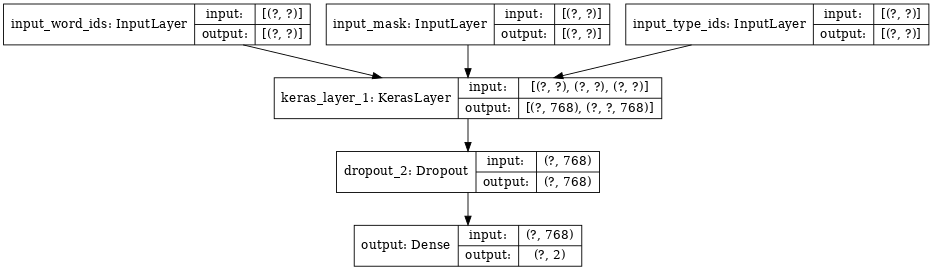

In [48]:
tf.keras.utils.plot_model(hub_classifier, show_shapes=True, dpi=64)

In [49]:
try:
  tf.keras.utils.plot_model(hub_encoder, show_shapes=True, dpi=64)
  assert False
except Exception as e:
  print(f"{type(e).__name__}: {e}")

AttributeError: 'KerasLayer' object has no attribute 'layers'


<a id="model_builder_functions"></a>

### Low level model building

If you need a more control over the construction of the model it's worth noting that the `classifier_model` function used earlier is really just a thin wrapper over the `nlp.modeling.networks.TransformerEncoder` and `nlp.modeling.models.BertClassifier` classes. Just remember that if you start modifying the architecture it may not be correct or possible to reload the pre-trained checkpoint so you'll need to retrain from scratch.

Build the encoder:

In [50]:
transformer_config = config_dict.copy()

# You need to rename a few fields to make this work:
transformer_config['attention_dropout_rate'] = transformer_config.pop('attention_probs_dropout_prob')
transformer_config['activation'] = tf_utils.get_activation(transformer_config.pop('hidden_act'))
transformer_config['dropout_rate'] = transformer_config.pop('hidden_dropout_prob')
transformer_config['initializer'] = tf.keras.initializers.TruncatedNormal(
          stddev=transformer_config.pop('initializer_range'))
transformer_config['max_sequence_length'] = transformer_config.pop('max_position_embeddings')
transformer_config['num_layers'] = transformer_config.pop('num_hidden_layers')

transformer_config

{'hidden_size': 768,
 'intermediate_size': 3072,
 'num_attention_heads': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522,
 'attention_dropout_rate': 0.1,
 'activation': <function official.modeling.activations.gelu.gelu(x)>,
 'dropout_rate': 0.1,
 'initializer': <tensorflow.python.keras.initializers.initializers_v2.TruncatedNormal at 0x7fac08046e10>,
 'max_sequence_length': 512,
 'num_layers': 12}

In [51]:
manual_encoder = nlp.modeling.networks.TransformerEncoder(**transformer_config)

Restore the weights:

In [52]:
checkpoint = tf.train.Checkpoint(model=manual_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

Test run it:

In [53]:
result = manual_encoder(my_examples, training=True)

print("Sequence output shape:", result[0].shape)
print("Pooled output shape:", result[1].shape)

Sequence output shape: (2, 23, 768)
Pooled output shape: (2, 768)


Wrap it in a classifier:

In [54]:
manual_classifier = nlp.modeling.models.BertClassifier(
        bert_encoder,
        num_classes=2,
        dropout_rate=transformer_config['dropout_rate'],
        initializer=tf.keras.initializers.TruncatedNormal(
          stddev=bert_config.initializer_range))

In [55]:
manual_classifier(my_examples, training=True).numpy()

array([[ 0.07863025, -0.02940944],
       [ 0.30274656,  0.27299827]], dtype=float32)

<a id="optiizer_schedule"></a>

### Optimizers and schedules

The optimizer used to train the model was created using the `nlp.optimization.create_optimizer` function:

In [56]:
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

That high level wrapper sets up the learning rate schedules and the optimizer.

The base learning rate schedule used here is a linear decay to zero over the training run:

In [57]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs

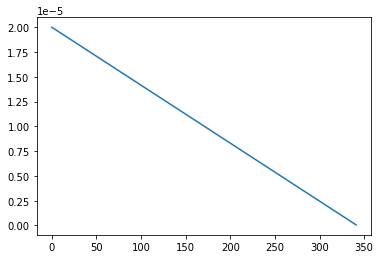

In [58]:
decay_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=2e-5,
      decay_steps=num_train_steps,
      end_learning_rate=0)

plt.plot([decay_schedule(n) for n in range(num_train_steps)])

This, in turn is wrapped in a `WarmUp` schedule that linearly increases the learning rate to the target value over the first 10% of training:

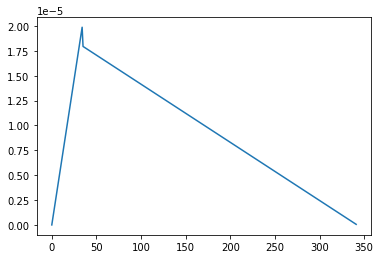

In [59]:
warmup_steps = num_train_steps * 0.1

warmup_schedule = nlp.optimization.WarmUp(
        initial_learning_rate=2e-5,
        decay_schedule_fn=decay_schedule,
        warmup_steps=warmup_steps)

# The warmup overshoots, because it warms up to the `initial_learning_rate`
# following the original implementation. You can set
# `initial_learning_rate=decay_schedule(warmup_steps)` if you don't like the
# overshoot.
plt.plot([warmup_schedule(n) for n in range(num_train_steps)])

Then create the `nlp.optimization.AdamWeightDecay` using that schedule, configured for the BERT model:

In [60]:
optimizer = nlp.optimization.AdamWeightDecay(
        learning_rate=warmup_schedule,
        weight_decay_rate=0.01,
        epsilon=1e-6,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'])